# Code for simulating the Morris Lecar neuron 

### importing libraries

In [209]:
from brian2 import *
import scipy.io as sio
%matplotlib inline

start_scope()

### reading input from the input theory file - saving it in a list

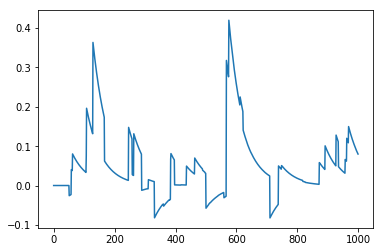

In [210]:
input_I = sio.loadmat('INPUT_THEORY1-10_new.mat')
INPUT = input_I['THEORY']
TimedA=[]
for x in nditer(INPUT):
    TimedA.append(x)

#check
plot(TimedA[0:1000])

### constants for model

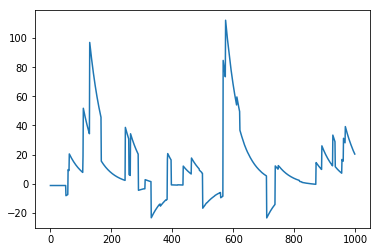

In [211]:
#constants for main model
C=2*ufarad
Bm=-1.2*mV 
phiw=0.15*kHz
gamma_m=18*mV
gamma_w=10*mV
gfast=20*mS  
E_Na=50*mV
gslow=20*mS 
E_K=-100*mV
gleak=2*mS
E_leak=-70*mV

#constants of scaling the input
Ihold=-1.2
Iscale=270

#new stimulus with scaling-creating new file with current
file=open("input-13-1-10.txt","w")
for i,x in enumerate(TimedA):
    x=Ihold+Iscale*x
    TimedA[i]=x
    file.write(str(TimedA[i])+'\n')
file.close()
    
#checking to see if values were added right
plot(TimedA[0:1000])

#making the stimulus
stimulus=TimedArray(TimedA*uamp,dt=0.1*ms)

## Main constant of model

In [212]:
Bw=-13*mV

### Model equations

In [213]:
eqs ='''
dV/dt=1/C*(stimulus(t)-gfast*hinf*(V-E_Na)-gslow*w*(V-E_K)-gleak*(V-E_leak)): volt
hinf = 0.5*(1+tanh((V-Bm)/gamma_m)) : 1
dw/dt= phiw*lambda_w*(winf-w) : 1
winf = 0.5*(1+tanh((V-Bw)/gamma_w)) : 1
lambda_w = cosh((V-Bw)/(2*gamma_w)) : 1
'''

### Neuron statement

In [214]:
G=NeuronGroup(1,eqs,dt=0.1*ms,method='euler',events={'custom_event1': 'w>1','custom_event2': 'w<0'})
initial_values = {'V': -70*mV, 'w': 0.}
G.set_states(initial_values)
G.run_on_event('custom_event1','w=1')
G.run_on_event('custom_event2','w=0')

Resetter(clock=Clock(dt=100. * usecond, name='neurongroup_2_clock_4'), when=after_resets, order=0, name='neurongroup_2_resetter_5')

### Monitor of Voltage

In [215]:
M = StateMonitor(G, 'V', record=True,dt=0.1*ms)

## Running the simulation

In [216]:
run(60000*ms,report='stdout',report_period=60*second)

WARNING    /home/tzikos/anaconda3/lib/python3.6/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /home/tzikos/.cython/brian_extensions/_cython_magic_8e50b6ec5cdb90ae4325be4b85974c27.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
 [py.warnings]


Starting simulation at t=0. s for a duration of 60. s
60.0 (100%) simulated in 32s


### Creating spiketrain output

In [217]:
file=open("spiketrain-13-1-10.txt","w")
count=0
spikes=0
const1=0
for j in range(60):
    listt=M.V[0][j*10000:j*10000+10000]
    for i,x in enumerate(listt):
        #print(i)
        if i==0:
            if const1<listt[i] and listt[i]>listt[i+1] and listt[i]>10*mV:
                file.write("1\n")
                spikes+=1
            else:
                file.write("0\n")        
        if (i>=1) and (i<=9998):
            if listt[i-1]<listt[i] and listt[i+1]<listt[i] and listt[i]>=10*mV:
                file.write("1\n")
                spikes+=1
            else:
                file.write("0\n")
        if i==9999:
            if M.V[0][j*10000+1]<listt[i] and listt[i]>listt[i-1] and listt[i]>10*mV:
                file.write("1\n")
                spikes+=1
            else:
                file.write("0\n")
        count+=1
    const1=listt[9999]
file.close()
print(count)
print(spikes)

600000
738


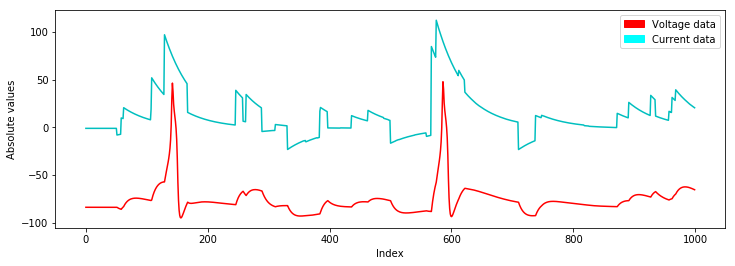

In [218]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt


figure(figsize=(12,4))
t=arange(0,1000,1)
red_patch = mpatches.Patch(color='red', label='Voltage data')
cyan_patch = mpatches.Patch(color='cyan', label='Current data')
legend(handles=[red_patch,cyan_patch])
ylabel("Absolute values")
xlabel("Index")
plot(t,TimedA[0:1000],'c',t,M.V[0][0:1000]*1200,'r')